In [1]:
from vivino_community_reviews import save_reviews, load_reviews
from vivino_community_reviews import vivino_reviews, concat_reviews, check_url

/home/lbk/.cache/pypoetry/virtualenvs/scrap2-pSsZr_wz-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import time

def read_csv(file, path_data, **kwargs):
    """
    kwargs: keyword args for pd.read_csv
    """
    files = [x for x in os.listdir(path_data) if x.startswith(file)]

    df_reviews = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f'{path_data}/{f}', **kwargs)
        df_reviews = pd.concat([df_reviews, df])

    return df_reviews.reset_index(drop=True)

# Existing

In [3]:
file = 'wine_reviews_'
df_reviews = read_csv(file, 'data')
df_reviews.groupby(['wid', 'wine']).review_transl.count().sort_index(level=1)

wid  wine                                                
4    Aguirre Dos Copas Cabernet Sauvignon                       7
35   Balbi Soprani Moscato d'Asti                              31
29   Bread & Butter Cabernet Sauvignon                         32
28   Bread & Butter Pinot Noir                               1236
33   Canti Moscato d'Asti                                      71
0    Casillero del Diablo Cabernet Sauvignon (Reserva)        472
6    Casillero del Diablo Chardonnay (Reserva)                122
39   Castello del Poggio Moscato d'Asti                        80
11   Cono Sur Bicicleta Reserva Unoaked Chardonnay            109
9    Frontera Cabernet Sauvignon                              207
38   G.D. Vajra Moscato d'Asti                                 52
36   Gancia Moscato d'Asti N.V.                               160
7    Kendall-Jackson Vintner's Reserve Cabernet Sauvignon     121
27   Kendall-Jackson Vintner's Reserve Chardonnay             553
10   Long Barn Cha

# Scraping

## Setting

In [4]:
locator_ratings = "//a[@href='#all_reviews']"
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_ratings,
    'loc2': locator_more,
    'loc3': locator_recent, 
    'loc4': locator_review,
    'loc5': locator_date
}

In [5]:
kwargs.update({
    'end_date': '20220101',
    'source': 'vivino',
    #'headless': True, # failed for background running 
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4
})

## wine list

In [6]:
file = 'data/wines_to_collect.txt'

with open(file, 'r') as f:
    w = f.read()

w = w.strip('\n').split('\n')
wines = {w[i]:w[i+1] for i in range(0, len(w), 2)}
len(wines)

10

In [7]:
# check if wine name and its url match or not
df = check_url(wines)

The top 5 pairs of least similarity:
0.69) Cono Sur Single Vineyard Syrah: cono-sur-santiago-single-vineyard-syrah-valle-de-san-antonio
0.83) Cono Sur Single Vineyard Cabernet Sauvignon: cono-sur-santiago-single-vineyard-cabernet-sauvignon
0.84) Cono Sur Single Vineyard Carmenere: cono-sur-santiago-single-vineyard-carmenere
0.85) Arione Moscato d'Asti: arione-moscato-d-asti
0.86) Cono Sur Single Vineyard Pinot Noir: cono-sur-santiago-single-vineyard-pinot-noir


In [8]:
id_start = df_reviews.wid.max() + 1
id_start

40

**load if the reviews of the wines not translated yet**

In [7]:
#files = []
files = ['wine_6']
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

data/wine_6.csv loaded.


wid
6    [Casillero del Diablo Chardonnay (Reserva)]
Name: wine, dtype: object

## Collect

**reset dataframe if no reviews unfinished**

In [9]:
df_reviews = pd.DataFrame()

In [10]:
num_try = 3 # num of try to scrape for failed wines

col_rev = ['wid', 'wine', 'date', 'review', 'source']
path = 'data'
wines_failed = dict()

for i in range(num_try):
    print(f'scraping {i+1}', '*'*20)
    #for wine_name, wine_url in wines:
    for wine_name, wine_url in wines.items():
        try:
            df = vivino_reviews(wine_url, wine_name, **kwargs)
            df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, path=path, id_start=id_start)
        except:
            print(f'ERROR: check {wine_name}')
            wines_failed.update({wine_name: wine_url})

    if len(wines_failed) > 0:
        print(f'num of failed: {len(wines_failed)}\n')
        wines = wines_failed
        wines_failed = dict()
        time.sleep(3)
    else:
        break

scraping 1 ********************


33it [00:04,  7.13it/s]


Arione Moscato d'Asti: 33 reviews collected.
data/wine_40.csv saved.


23it [00:25,  1.10s/it]

Catena Cabernet Sauvignon: 23 reviews collected.
data/wine_41.csv saved.



0it [00:00, ?it/s]


ERROR: check Cono Sur Single Vineyard Syrah


0it [00:00, ?it/s]


ERROR: check Cono Sur Single Vineyard Cabernet Sauvignon


0it [00:00, ?it/s]


ERROR: check Cono Sur Single Vineyard Pinot Noir


0it [00:00, ?it/s]


ERROR: check Cono Sur Single Vineyard Carmenere


0it [00:00, ?it/s]


ERROR: check Cono Sur Single Vineyard Chardonnay


83it [01:23,  1.01s/it]

Two Hands Angels' Share Shiraz: 83 reviews collected.
data/wine_42.csv saved.



103it [01:14,  1.38it/s]


Two Hands Gnarly Dudes Shiraz: 103 reviews collected.
data/wine_43.csv saved.


83it [00:57,  1.44it/s]


Two Hands Sexy Beast Cabernet Sauvignon: 83 reviews collected.
data/wine_44.csv saved.
num of failed: 5

scraping 2 ********************


33it [00:04,  6.90it/s]


Cono Sur Single Vineyard Syrah: 33 reviews collected.
data/wine_45.csv saved.


33it [00:04,  6.90it/s]


Cono Sur Single Vineyard Cabernet Sauvignon: 33 reviews collected.
data/wine_46.csv saved.


43it [00:07,  6.09it/s]


Cono Sur Single Vineyard Pinot Noir: 43 reviews collected.
data/wine_47.csv saved.


13it [00:00, 38452.72it/s]


Cono Sur Single Vineyard Carmenere: 13 reviews collected.
data/wine_48.csv saved.


243it [05:06,  1.26s/it]

Cono Sur Single Vineyard Chardonnay: 243 reviews collected.
data/wine_49.csv saved.


In [11]:
df_reviews

,wid,wine,date,review,source
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino
...,...,...,...,...,...
238,49,Cono Sur Single Vineyard Chardonnay,2021-11-05,Citrus top note Decent Chardonnay,vivino
239,49,Cono Sur Single Vineyard Chardonnay,2021-10-31,Good. Balanced.,vivino
240,49,Cono Sur Single Vineyard Chardonnay,2017-09-13,Bright straw colour. Pure nose unoaked style w...,vivino
241,49,Cono Sur Single Vineyard Chardonnay,2022-08-20,butter citrus nice chardonnay under 20$,vivino


**temp saving before translation**

In [12]:
df_reviews.groupby(['wid', 'wine']).review.count().sort_index(level=1)

wid  wine                                       
40   Arione Moscato d'Asti                           33
41   Catena Cabernet Sauvignon                       23
46   Cono Sur Single Vineyard Cabernet Sauvignon     33
48   Cono Sur Single Vineyard Carmenere              13
49   Cono Sur Single Vineyard Chardonnay            243
47   Cono Sur Single Vineyard Pinot Noir             43
45   Cono Sur Single Vineyard Syrah                  33
42   Two Hands Angels' Share Shiraz                  83
43   Two Hands Gnarly Dudes Shiraz                  103
44   Two Hands Sexy Beast Cabernet Sauvignon         83
Name: review, dtype: int64

In [13]:
save_reviews(df_reviews, 'wine_reviews_tmp.csv', 'data', overwrite=True)

data/wine_reviews_tmp.csv saved.


# Review data

In [14]:
df_reviews = load_reviews('wine_reviews_tmp.csv', 'data')

data/wine_reviews_tmp.csv loaded.


In [15]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
18,40,Arione Moscato d'Asti,2021-10-30,NaN,vivino
33,41,Catena Cabernet Sauvignon,2024-02-05,NaN,vivino
34,41,Catena Cabernet Sauvignon,2024-02-04,NaN,vivino
35,41,Catena Cabernet Sauvignon,2024-01-27,NaN,vivino
53,41,Catena Cabernet Sauvignon,2016-06-10,NaN,vivino
136,42,Two Hands Angels' Share Shiraz,2020-03-01,NaN,vivino
239,43,Two Hands Gnarly Dudes Shiraz,2023-08-22,NaN,vivino
322,44,Two Hands Sexy Beast Cabernet Sauvignon,NaT,NaN,vivino
355,45,Cono Sur Single Vineyard Syrah,2018-11-16,NaN,vivino
380,46,Cono Sur Single Vineyard Cabernet Sauvignon,2021-01-24,NaN,vivino


In [16]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [17]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024     24
2023    259
2022    248
2021     96
2020     35
2019      6
2018      2
2017      4
2016      3
Name: count, dtype: int64

In [18]:
kwargs['end_date']

'20220101'

<Axes: >

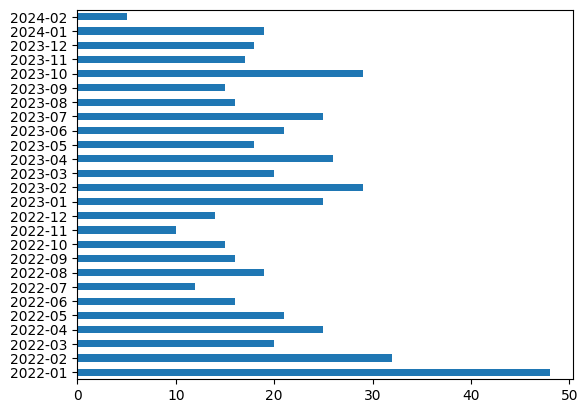

In [19]:
#d = df_reviews.date.agg(['min', 'max']).to_list()
d = [kwargs['end_date'], df_reviews.date.max()]

date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

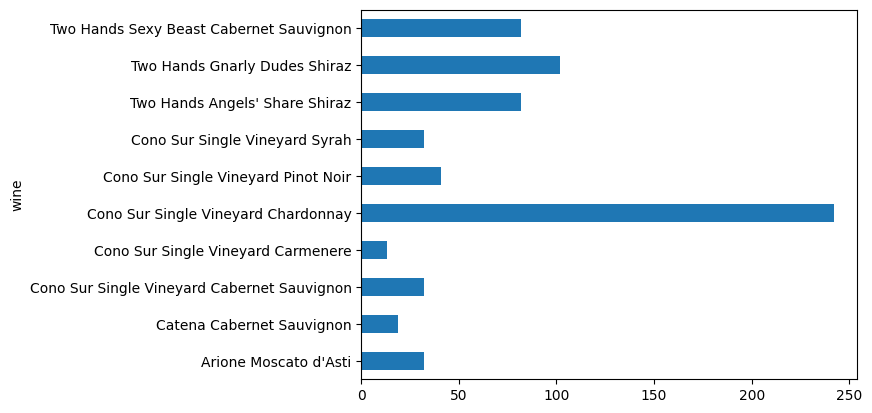

In [20]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [21]:
df_reviews.head()

,wid,wine,date,review,source
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino


# Translate

In [22]:
import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [23]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append({
        #'wid': rec['wid'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])
    })

100%|█████████████████████████████████████████████████████████████| 677/677 [07:52<00:00,  1.43it/s]


In [24]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data), left_index=True, right_index=True)
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino,it,pear peach tropical note minerals
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino,it,Optimal
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino,ko,"A slightly refreshing scent, a bit of body whe..."
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino,es,"Fruity, delicious."
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino,en,honey apple peach citrus Slight fizziness ligh...


**check translation error**

In [25]:
cond = df_reviews.lang.str.contains('ERROR')
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl
337,45,Cono Sur Single Vineyard Syrah,2021-05-23,2.0,vivino,<-- ERROR -->,2.0
411,47,Cono Sur Single Vineyard Pinot Noir,2020-10-01,👍,vivino,<-- ERROR -->,None
455,49,Cono Sur Single Vineyard Chardonnay,2019-07-23,"19,",vivino,<-- ERROR -->,"19,"
553,49,Cono Sur Single Vineyard Chardonnay,2022-09-19,20220919,vivino,<-- ERROR -->,20220919
591,49,Cono Sur Single Vineyard Chardonnay,2022-05-11,79,vivino,<-- ERROR -->,79
634,49,Cono Sur Single Vineyard Chardonnay,2022-02-10,ㅇㅇ,vivino,<-- ERROR -->,yep


In [ ]:
#cond = df_reviews.review_transl.isna()
#df_reviews.loc[cond]

In [26]:
df_reviews = df_reviews.loc[~cond]

**save final data**

In [28]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
#d = f'{d}b'
save_reviews(df_reviews, f'wine_reviews_{d}.csv')

data/wine_reviews_240213b.csv saved.


In [33]:
!unzip -l wine_reviews.zip

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   343369  2024-02-07 16:58   wine_reviews_240124.csv
   334512  2024-02-07 18:16   wine_reviews_240207.csv
   529775  2024-02-12 20:13   wine_reviews_240212.csv
   213076  2024-02-13 16:19   wine_reviews_240213a.csv
   176652  2024-02-13 18:27   wine_reviews_240213b.csv
---------                     -------
  1597384                     5 files


In [30]:
!zip -uj wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240213.csv (deflated 71%)


In [32]:
!zip -j wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240124.csv (deflated 70%)
  adding: wine_reviews_240207.csv (deflated 69%)
  adding: wine_reviews_240212.csv (deflated 73%)
  adding: wine_reviews_240213a.csv (deflated 71%)
  adding: wine_reviews_240213b.csv (deflated 69%)
